In [97]:
import requests
import unidecode
import collections
import itertools

from crossref.restful import Journals, Works
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
# Functions that should be outsourced        

# Define function for text preprocessing and inferring its vector (model should be)
def vector_represent(text,model):
    
    # Remove stopwords
    p_text = remove_stopwords(text)
    # Preprocess
    p_text = gensim.utils.simple_preprocess(p_text, max_len=30)
    # Get vector
    vector = model.infer_vector(p_text)
    #tagged_text = gensim.models.doc2vec.TaggedDocument(p_text, [i])
    return vector

 

# Function to preprocess a text document and turn it into a tagged document
def generate_corpus(text_docs):
    corpus = []
    for i, text_doc in enumerate(text_docs):
        prep_text = gensim.utils.simple_preprocess(text_doc, max_len=30)
        tagged_doc = gensim.models.doc2vec.TaggedDocument(prep_text, [i])
        corpus.append(tagged_doc)
    return corpus



In [141]:
#Classes necessary for the 
# SKLearn-style wrapper to generate a doc2vec document model
class DocVectorizer(BaseEstimator):
    
    def __init__(self):
        self.model = None
        pass

    def fit(self, train, test, y=None):
        # Initialize model
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=3, epochs=40)
        # Build model vocabulary
        corp = generate_corpus(train)
        self.model.build_vocab(corp)
        # Build model 
        self.model.train(corp, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def transform(self, x_dataset):
        if isinstance(x_dataset,str):
            return pd.DataFrame([vector_represent(x_dataset,self.model)])
        else:
            return pd.DataFrame([vector_represent(x,self.model) for x in x_dataset])

In [142]:
d2v = DocVectorizer()
clf = xgb.XGBClassifier(max_depth=5, objective='multi:softmax', n_estimators=2000, num_classes=6)

In [143]:
pipeline_test = make_pipeline(d2v,clf)

In [144]:
pipeline_test.fit(X_train,y_train)

Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(max_depth=5, n_estimators=2000, num_classes=6,
                               objective='multi:softprob'))])

In [145]:
# LogClassifier: Generating predictions 
predictions_train = pipeline_test.predict(X_train)
predictions_test = pipeline_test.predict(X_test)

In [146]:
print("Training accuracy: "+str(accuracy_score(y_train, predictions_train)))
print("Test accuracy: "+str(accuracy_score(y_test,predictions_test)))

Training accuracy: 0.9814640698455339
Test accuracy: 0.49946294307196565


## Scrape journal abstracts

Approach: use crossref to obtain the DOIs, then use Springer to obtain abstracts. Journals: Philosophical studies, Synthese,..?

In [120]:
# Defining constants with the journal names
SYN = "Synthese"
PS = "Philosophical Studies"
PT = "Philosophy & Technology"
ERK = "Erkenntnis"
JPL = "Journal of Philosophical Logic"
MM = "Minds and Machines"

In [133]:
journals = Journals()
works = Works()

In [134]:
# Synthese e-ISSN
synthese_issn = "1573-0964"
# Philosophical studies e-ISSN
ps_issn = "1573-0883"
# Philosophy and Technology e-ISSN
pt_issn = "2210-5441"
# Erkenntnis e-ISSN
erk_issn = "1572-8420"
# JPL e-ISSN
jpl_issn = "1573-0433"
# Minds and Machines
mm_issn = "1572-8641"

# Put into list
issns = [synthese_issn, ps_issn, pt_issn, erk_issn, jpl_issn, mm_issn]

In [135]:
journals.journal(erk_issn).get("title")

'Erkenntnis'

In [5]:
# Delete after running
issns = [erk_issn, jpl_issn, mm_issn]

entries = []

# Link to documentation? What is the API call limit?

# Get all DOI's from each journal

for issn in issns:
    for i, article in enumerate(journals.works(issn)):
        try:
            title = unidecode.unidecode(article["title"][0])
            given_name = unidecode.unidecode(article["author"][0].get("given"))
            family_name = unidecode.unidecode(article["author"][0].get("family"))
            doi = article["DOI"]
            type_ = article["type"]
            year = article["published-print"].get("date-parts")[0][0]
            journal = journals.journal(issn).get("title")
        
            # Create list with all the entry elements
            entry = [title, given_name, family_name, doi, type_, year, journal]
            entries.append(entry)
            print(f"Entry {i}: {title}")
        except:
            print(f"Could not extract")
    
    
# Turn into dataframe
df_journals = pd.DataFrame(entries, columns=["Title","First name","Last name","DOI","Type","Year","Journal"])

# Save to CSV
df_journals.to_csv("data/crossref_dois_journals_p2.csv")

Entry 0: What is the 'Cause' in Causal Decision Theory?
Entry 1: The computable testability of theories making uncomputable predictions
Entry 2: Non-contractability and Revenge
Entry 3: Conditional intentions, intentional action and Aristotelian practical syllogisms
Entry 4: Review
Entry 5: Zur Rolle der Entscheidungstheorie bei der Rechtfertigung von Gerechtigkeitsprinzipien?Kritische berlegungen im Anschluss an Rawls
Entry 6: Once again pure exchange economies: A critical view towards the structuralistic reconstructions by Balzer and Stegmller
Entry 7: Doxastic Voluntarism and the Function of Epistemic Evaluations
Entry 8: Bemerkungen zum Grundlagenstreit in Logik und Mathematik
Could not extract
Entry 10: Hierarchy versus holism: A structuralist view on general relativity
Entry 11: Nonclassical Probability and Convex Hulls
Entry 12: Action sentences
Entry 13: Of Miracles and Interventions
Entry 14: Two Conceptions of Language
Could not extract
Could not extract
Entry 17: Book review

Entry 161: Reconciling Enkrasia and Higher-Order Defeat
Could not extract
Entry 163: The Discrimination Argument Revisited
Entry 164: Evidence and Knowledge
Entry 165: Coextensiveness and lawlikeness
Could not extract
Entry 167: Actuality, Tableaux, and Two-Dimensional Modal Logics
Entry 168: The use theory of meaning and semantic stipulation
Could not extract
Entry 170: Verisimilitude and Belief Change for Conjunctive Theories
Entry 171: An Economic Paradox: The Sophism of the Heap of Wheat and Statistical Truths
Entry 172: Proper names as variables
Entry 173: Reichenbach's Transcendental Probability
Entry 174: The Real Puzzle From Radford
Entry 175: In Defense of Idealization in Public Reason
Entry 176: Agreement and Communication
Entry 177: Structuralist constraints and mathematical social theorizing
Entry 178: Introduction
Entry 179: Obituary of Sir Alfred Ayer (1910-1989)
Entry 180: Incomplete descriptions
Entry 181: A Situationalist Solution to the Ship of Theseus Puzzle
Entry 18

Entry 309: The social sciences and unified science
Entry 310: The problem solving ability of the rule utilitarian approach should not be underestimated: Comments on Scanlon's paper
Could not extract
Entry 312: Impartial welfarism and the concept of a person
Entry 313: What makes it a heap?
Could not extract
Could not extract
Entry 316: Review
Could not extract
Entry 318: Relativistic hidden variable theories?
Entry 319: The Problem of Phantom Functions
Entry 320: Anchoring in Deliberations
Entry 321: Jordan, Quantentheorie und Willensfreiheit:
Could not extract
Entry 323: Errata-band 3
Entry 324: A Puzzle About Desire
Entry 325: Introduction
Entry 326: Coherence as Generalized Logical Equivalence
Entry 327: Dretske on Self-Knowledge and Contrastive Focus: How to Understand Dretske's Theory, and Why It Matters
Could not extract
Could not extract
Entry 330: Accidental (?non-substantial?) theory change and theory dislodgement: To what extent logic can contribute to a better understanding 

Entry 467: The Identity of Living Beings, Epigenetics, and the Modesty of Philosophy
Entry 468: Self-Deception and Stubborn Belief
Entry 469: The Concept of Inductive Probability
Entry 470: Two Problems of Direct Inference
Entry 471: Necessary Connections in Context
Entry 472: "Induktionslogik" und "Hypothesen-wahrscheinlichkeit":
Entry 473: Dynamics and Diversity in Epistemic Communities
Entry 474: A Quantum-Mechanical Argument for Mind-Body Dualism
Entry 475: Prospects for Probabilistic Theories of Natural Information
Entry 476: Ontological Choices and the Value-Free Ideal
Could not extract
Entry 478: Convex models of uncertainty: Applications and implications
Entry 479: Mixed strategies and ratifiability in causal decision theory
Entry 480: Composition as Identity Does Not Entail Universalism
Entry 481: Coordination in Thought
Entry 482: Bayesianism for Non-ideal Agents
Entry 483: Entity Realism About Mental Representations
Could not extract
Entry 485: Skepticism, Information, and C

Entry 623: Three observations on Languages of Art
Could not extract
Entry 625: Approximate probability and expectation of gambles
Entry 626: The Logic of Fast and Slow Thinking
Entry 627: Interpreting formal logic
Entry 628: Quantum theory as a theory of interactions between macroscopic systems which can be described objectively
Entry 629: Bootstrapping and Content Parts
Could not extract
Entry 631: Unarticulated meaning
Entry 632: Skepticism: The Hard Problem for Indirect Sensitivity Accounts
Entry 633: On the formal connection of the Einstein-Podolsky-Rosen argument to quantum mechanics and reality
Entry 634: On the Truth-Conduciveness of Coherence
Could not extract
Entry 636: Goals and the Informativeness of Prior Probabilities
Entry 637: A Different Sort of Contextualism
Entry 638: Two Concepts of Plausibility in Default Reasoning
Entry 639: Pristinism under Pressure: Ruetsche on the Interpretation of Quantum Theories
Entry 640: An Isolation Objection to Phenomenal Conservatism
Ent

Entry 777: Axiomatic basis of equilibrium classical thermodynamics
Entry 778: Book review
Entry 779: Limits of inquiry
Entry 780: An ordinal modification of classical utilitarianism
Entry 781: Die Heilung durch den Geist
Entry 782: Colour, world and archimedean metaphysics: stroud and the quest for reality
Entry 783: Works, works better
Entry 784: Moral realism and moral judgments
Entry 785: Causal Emergence and Epiphenomenal Emergence
Entry 786: No Interpretation of Probability
Entry 787: Stability, Strength and Sensitivity:Converting Belief into Knowledge
Entry 788: The Practical Origins of Epistemic Contextualism
Entry 789: Undesigned Coincidences and Coherence for an Hypothesis
Entry 790: Group Agents are Not Expressive, Pragmatic or Theoretical Fictions
Entry 791: Causal relevance and Nonreductive physicalism
Entry 792: Preface to Mental Causation, Externalism and Self-Knowledge
Entry 793: Epistemic Authority, Philosophical Explication, and the Bio-Statistical Theory of Disease
En

Entry 939: Selection and Predictive Success
Entry 940: Epistemic Deontology and Voluntariness
Could not extract
Entry 942: Combining Analogical Support in Pure Inductive Logic
Entry 943: Response-dependence, rigidification and objectivity
Entry 944: Towards a New Epistemology of Mathematics
Entry 945: The significance of epistemic correlations in scientific method
Entry 946: Forcing and the indeterminacy of translation
Entry 947: The Metaphysics and Politics of Corporate Personhood
Entry 948: Die Frage nach der Endlichkeit des Weltraums, als astronomisches Problem behandelt
Entry 949: Paradoxes of infinity and self-applications, I
Entry 950: Interventions and Causality in Quantum Mechanics
Entry 951: Zur Induktions-Maschine:
Entry 952: Uber den sogenannten Gegenstand der Mathematik
Entry 953: Review
Entry 954: Belief Revision and Verisimilitude Based on Preference and Truth Orderings
Entry 955: An axiomatic basis for distributional equality in utilitarianism
Entry 956: Moral Twin-Earth

Entry 1105: The conceptual foundations of contemporary relativity theory
Could not extract
Entry 1107: The Moral Objection to Modal Realism
Entry 1108: Holismus und theorienbeladenheit der beobachtungssprache (ein beispiel)
Entry 1109: Systems theory and the problem of reductionism
Could not extract
Entry 1111: Atoms, Gunk, and the Limits of 'Composition'
Entry 1112: Borel on the Heap
Entry 1113: Generalized probability kinematics
Entry 1114: On theoretical terms
Could not extract
Entry 1116: The Implicit Commitment of Arithmetical Theories and Its Semantic Core
Entry 1117: Book review
Entry 1118: Incommensurability and inconsistency of languages
Entry 1119: On the location of actions and tryings: Criticism of an internalist view
Entry 1120: Zur logikabhngigkeit wissenschafts-theoretischer Paradoxien
Entry 1121: Magicicada, Mathematical Explanation and Mathematical Realism
Entry 1122: Names as Devices of Explicit Co-reference
Entry 1123: Free Will and Desire
Could not extract
Could not

Entry 1276: Comments on L. H. Davis, ?what it is like to be an agent?
Entry 1277: Paul A. Boghossian, Fear of Knowledge: Against Relativism and Constructivism
Entry 1278: Referate und diskussionen
Entry 1279: A Renewed Challenge to Anti-criterialism
Entry 1280: Broken bootstraps
Entry 1281: Neutral Predication
Entry 1282: Supervenience and reductionism
Could not extract
Entry 1284: Preface
Entry 1285: The Reasons-Responsiveness Account of Doxastic Responsibility and the Basing Relation
Entry 1286: Theory-change as structure-change: Comments on the sneed formalism
Entry 1287: Causal Realism: Events and Processes
Entry 1288: The Innocence of Truth in Semantic Paradox
Entry 1289: Reference problems in stoichiometry
Could not extract
Entry 1291: John Rawls and the liberal theory of society
Entry 1292: The Basis of Self-Knowledge
Entry 1293: Bemerkungen zu den bibliographischen Notizen:
Entry 1294: Meanings in multi-valued logics
Entry 1295: Comment on Jeffrey (?Smith & Jones?)
Entry 1296: 

Entry 1429: Stochastic Independence and Causal Connection
Entry 1430: What Angles Can Tell Us About What Holes Are Not
Entry 1431: Platitudes against Paradox
Entry 1432: Frege's objects of a quite special kind
Entry 1433: A modest concept of moral sense perception
Entry 1434: Concerning the negation of empirical propositions
Entry 1435: Critical Discussion
Entry 1436: Theory and measurement
Entry 1437: Metaphysics and the Vera Causa Ideal: The Nun's Priest's Tale
Could not extract
Entry 1439: Anything is possible
Entry 1440: Concerning this republication of the Annalen der philosophie und philosophischen kritik and erkenntnis
Entry 1441: Do we have to be Realists about Colour in order to be able to attribute Colour Perceptions to Other Persons?
Entry 1442: Meaning and Formal Semantics in Generative Grammar
Entry 1443: The interrogative approach to inquiry and probabilistic inference
Entry 1444: Mental Causation and the Agent-Exclusion Problem
Could not extract
Entry 1446: Monty Hall Sa

Entry 1593: Book review
Entry 1594: Arbitrage arguments
Entry 1595: Deontic Logic for Strategic Games
Entry 1596: Objective Content
Entry 1597: Inferential Contextualism, Epistemological Realism and Scepticism: Comments on Williams
Entry 1598: Did Einstein Stumble? The debate over general covariance
Entry 1599: Events
Could not extract
Entry 1601: Presentism and Einstein's Train of Thought: Reply to Brogaard and Marlow
Entry 1602: A priori truth
Entry 1603: Some aspects of recent American scientific philosophy:
Entry 1604: Hybrid Indexicals and Ellipsis
Entry 1605: Intertheoretical Identity And Ontological Reductions
Entry 1606: Zur verteidigung einiger hempelscher thesen gegen kritiken stegmllers
Entry 1607: Review
Entry 1608: Introspective Self-Knowledge and Reasoning: An Externalist Guide
Entry 1609: Mental Causation and the Metaphysics of Causation
Could not extract
Entry 1611: Thinking about Non-Universal Laws
Entry 1612: Piron's approach to the foundations of quantum mechanics
En

Entry 1750: Color primitivism
Entry 1751: Internalism About Justification and the Skeptic's Dilemma
Entry 1752: The Combination Problem: Subjects and Unity
Entry 1753: Review
Entry 1754: Bericht uber untersuchungen zur allgemeinen Axiomatik
Entry 1755: Book review
Entry 1756: Learning from Simple Indicative Conditionals
Entry 1757: Measurement
Could not extract
Could not extract
Entry 1760: Russell and Schlick
Entry 1761: Logik der Forfchung. Zur Erkenntnistheorie der modernen Naturwiffenfchaft
Entry 1762: Book Review
Entry 1763: Vom Henker, vom Lgner und von Ihrem Ende
Entry 1764: Book review
Entry 1765: Revamping Hypothetico-Deductivism: A Dialectic Account of Confirmation
Could not extract
Could not extract
Entry 1768: Logical foundations of psychoanalytic theory
Entry 1769: Moral Responsibility for Actions and Omissions: The Asymmetry Thesis Rejected
Entry 1770: Not Wanted: On Scharp's Solution to the Liar
Could not extract
Entry 1772: Understanding Embryos in a Changing and Comple

Entry 1901: A reason for theoretical terms
Entry 1902: Do Compatibilists Need Alternative Possibilities?
Entry 1903: Scientific Realism: Old and New Problems
Could not extract
Entry 1905: Sprachverstehende maschinen
Could not extract
Entry 1907: Dispositions and Tricks
Entry 1908: On the simplicity of curve hypotheses
Entry 1909: How to discover that the real is unreal
Entry 1910: The Nought Belief Paradox
Entry 1911: Zur Gefchichte der Ausfagenlogik:
Entry 1912: Introduction and Overview
Entry 1913: Deontic logic and the possibility of moral conflict
Entry 1914: Genetic Models in Evolutionary Game Theory: The Evolution of Altruism
Entry 1915: On Doxastic Justification and Properly Basing One's Beliefs
Entry 1916: ?Coordinative definition? and Reichenbach's semantic framework: A reassessment
Entry 1917: Epistemic Self-Trust and Doxastic Disagreements
Entry 1918: Book review
Could not extract
Entry 1920: Anything and Everything
Entry 1921: Balint's Syndrome, Visual Motion Perception, an

Entry 2063: Objectivism and subjectivism in the foundations of statistics
Entry 2064: On the status of arithmetic
Entry 2065: Expressing Disagreement: A Presuppositional Indexical Contextualist Relativist Account
Entry 2066: Is Objectual Identity Really Dispensable?
Entry 2067: Extensionality, underdetermination and indeterminacy
Could not extract
Entry 2069: On innertheoretical conditions for theoretical terms
Could not extract
Entry 2071: Die logifchen Grundlagen des Wahrfcheinlichkeitsbegriffs
Could not extract
Entry 2073: Ramsey Equivalence
Entry 2074: Quine and Logical Truth
Could not extract
Could not extract
Entry 2077: Russell and the Temporal Contiguity of Causes and Effects
Could not extract
Could not extract
Entry 2080: Epistemic Modals and Alternative Possibilities
Entry 2081: Dicing with Saul Kripke
Entry 2082: An improved definition of ?theoretical in a given theory?
Entry 2083: Wirtfchaftspolitik als Wiffenfchaft
Could not extract
Entry 2085: Preface
Entry 2086: Economic

Entry 2229: Counterfactual Reasoning, Realism and Quantum Mechanics: Much Ado About Nothing?
Entry 2230: Scientific Knowledge and Extended Epistemic Virtues
Entry 2231: A Sketch of a Presentist Theory of Passage
Entry 2232: Two logical connection arguments and some principles about causal connection
Entry 2233: On the logic of causally necessary and sufficient conditions: Towards a theory of motive-explanations of human actions
Entry 2234: Review
Entry 2235: Interventionism and Mental Surgery
Entry 2236: Hans Hahn
Entry 2237: Utility and its ambiguities
Could not extract
Entry 2239: Pluralism and Proofs
Could not extract
Entry 2241: Four Meta-methods for the Study of Qualia
Entry 2242: Entities Without Identity: A Semantical Dilemma
Entry 2243: Some comments on the projectibility of anthropological hypotheses: Samoa briefly revisited
Entry 2244: Replies
Entry 2245: A specious puzzle
Entry 2246: Contingent Objects and the Barcan Formula
Entry 2247: On empirically equivalent systems of t

Entry 2382: Would the Existence of CTCs Allow for Nonlocal Signaling?
Entry 2383: Some remarks on a paper by P. Suppes
Could not extract
Could not extract
Entry 2386: Review
Entry 2387: Epistemic Disagreement and Practical Disagreement
Entry 2388: The Parallel Goods of Knowledge and Achievement
Entry 2389: Throwing Darts, Time, and the Infinite
Entry 2390: The Poznan school methodology of idealization and concretization from the point of view of a revised structuralist theory conception
Entry 2391: Perceptual Learning and the Contents of Perception
Entry 2392: X-Phi and Carnapian Explication
Entry 2393: Uber die Ziele und Probleme der Logiftik
Entry 2394: David Bostock: Philosophy of Mathematics: An Introduction
Entry 2395: Out of the belief trap
Entry 2396: Philosophy of Science: What are the Key Journals in the Field?
Could not extract
Entry 2398: Note on an argument of W. Ochs against the ignorance interpretation of state in quantum mechanics
Entry 2399: A Constitutive Account of Gr

Entry 2539: Self-Intimation and Second Order Belief
Entry 2540: Review
Could not extract
Entry 2542: Restall's Proof-Theoretic Pluralism and Relevance Logic
Entry 2543: Der logiftifche Antiirrationalismus in Polen:
Entry 2544: Truth, Revenge, and Internalizability
Entry 2545: The Counterfactual Structure of the Consequence Argument
Entry 2546: Deductive Reasoning Under Uncertainty: A Water Tank Analogy
Could not extract
Entry 2548: Preface Special Issue GAP.10
Entry 2549: Goldman On Knowledge As True Belief
Entry 2550: Hegel, science, and set theory
Entry 2551: Book Reviews
Could not extract
Could not extract
Entry 2554: Contextualist Approaches to Epistemology: Problems and Prospects
Entry 2555: An empirical basis for charity in interpretation
Entry 2556: Putnam's Diagonal Argument and the Impossibility of a Universal Learning Machine
Entry 2557: Syntax-directed discovery in mathematics
Entry 2558: Some remarks on hidden variables and the EPR paradox
Entry 2559: Epistemic Contextualis

Entry 2703: A note on functional explanation
Entry 2704: Wahrheit von innen und aussen
Entry 2705: Lehrbuch der experimentellen Psychologie
Entry 2706: Comment on Baier's paper
Entry 2707: Erratum to: Using Natural-Kind Essentialism to Defend Dispositionalism
Entry 2708: Tarski's Theorem and the Extensionality of Truth
Entry 2709: Dualism and Exclusion
Entry 2710: Anmerkungen zum Kausalproblem
Could not extract
Entry 2712: The Problem of Trope Individuation: A Reply to Lowe
Entry 2713: Moral Valence and Semantic Intuitions
Entry 2714: Probabilistic Approaches to Vagueness and Semantic Competency
Could not extract
Could not extract
Entry 2717: Heidegger und der Tod
Entry 2718: Philosophical problems in the Empirical science of science: A formal approach
Entry 2719: Intergenerational Rights and the Problem of Cross-Temporal Relations
Entry 2720: Contextualism and Disagreement
Entry 2721: Explanation and Modality: On the Contingency Horn of Blackburn's Dilemma
Entry 2722: Conditions on up

Entry 39: Synthetic mechanics
Entry 40: Logic and the Condemnations of 1277
Entry 41: Counterfactuals and substitution of equivalent antecedents
Entry 42: Relevant predication: Grammatical characterisations
Entry 43: A free logic with intensions as possible values of terms
Entry 44: The logical structure of linguistic commitment II: Systems of relevant commitment entailment
Entry 45: Individual-actualism and three-valued modal logics, part 1: Model-theoretic semantics
Entry 46: The deducibilities of S5
Entry 47: On Chisholm's paradox
Entry 48: Universal semantics?
Entry 49: Non-Prioritized Ranked Belief Change
Entry 50: Efficient reasoning about rich temporal domains
Entry 51: Some numerical constructions in English
Entry 52: A Simple Incomplete Extension of T which is the Union of Two Complete Modal Logics with f.m.p.
Entry 53: Logical consequence: A defense of Tarski
Entry 54: The Modal Logic of Discrepancy
Could not extract
Entry 56: Ontology, Set Theory, and the Paraphrase Challeng

Entry 190: Probabilistic semantics objectified: I. postulates and logics
Entry 191: Gleason's theorem is not constructively provable
Entry 192: Goodman's "New Riddle"
Entry 193: A new theory of content I: Basic content
Entry 194: On AGM for Non-Classical Logics
Entry 195: Natural Deduction and Curry's Paradox
Entry 196: Truth, belief, and vagueness
Entry 197: Naive Modus Ponens
Entry 198: External Curries
Entry 199: The Simple Consistency of Naive Set Theory using Metavaluations
Could not extract
Entry 201: The logic of essence
Entry 202: Bolzano's consequence, relevance, and enthymemes
Entry 203: A posts cript on fallacies
Entry 204: Concrete forms ? Their application to the logical paradoxes and Gdel's theorem
Entry 205: Contingent identity
Entry 206: A Relevant Logic of Questions
Entry 207: Potential Infinite Models and Ontologically Neutral Logic
Entry 208: Defaults in update semantics
Entry 209: The Problem of Cross-world Predication
Entry 210: Measuring Inconsistency
Entry 211: S

Entry 346: A correlation between modal reduction principles and properties of relations
Entry 347: Some semantically closed languages
Entry 348: The Irreducibility of Iterated to Single Revision
Entry 349: First-order Expressivity for S5-models: Modal vs. Two-sorted Languages
Entry 350: Frege, Boolos, and Logical Objects
Entry 351: An incomplete system of modal logic
Entry 352: On Possible Worlds with Modal Parts
Entry 353: Toward a More Natural Expression of Quantum Logic with Boolean Fractions
Entry 354: On qualitative axiomatizations for probability theory
Entry 355: A Theory of Hypermodal Logics: Mode Shifting in Modal Logic
Entry 356: AN INTUITIONISTIC CHARACTERIZATION OF CLASSICAL LOGIC
Entry 357: Consequence Relations and Admissible Rules
Entry 358: The logic of ground
Entry 359: Some Notes on Truths and Comprehension
Entry 360: Relevant consequence and empirical inquiry
Entry 361: First-Order Frege Theory is Undecidable
Entry 362: Validity, the Squeezing Argument and Alternativ

Entry 493: Probability Modals and Infinite Domains
Entry 494: Modality, Quantification, and Many Vlach-Operators
Entry 495: Some remarks on extending and interpreting theories with a partial predicate for truth
Entry 496: Generalising the probabilistic semantics of conditionals
Entry 497: Yes, Virginia, there Really are Paraconsistent Logics
Entry 498: Context-dependent Abduction and Relevance
Entry 499: Conditionals, quantification, and strong mathematical induction
Entry 500: Intensional logics without interative axioms
Entry 501: A warning about the choice of primitive operators in modal logic
Entry 502: A subjective interpretation of conditional probability
Entry 503: Semantics for existential graphs
Entry 504: A Rational Way of Playing: Revision Theory for Strategic Interaction
Entry 505: Predicative foundations of arithmetic
Entry 506: A refined theory of counterfactuals
Entry 507: Is (quantum) logic empirical?
Entry 508: The One-Variable Fragment of T-
Could not extract
Entry 51

Entry 632: Reply to Sorensen
Entry 633: Translation and reduction
Entry 634: The Genesis of Possible Worlds Semantics
Entry 635: Assertoric Semantics and the Computational Power of Self-Referential Truth
Entry 636: A Dynamic Characterization of the Pure Logic of Relevant Implication
Entry 637: Indexed systems of sequents and cut-elimination
Entry 638: Direct reference and ascriptions of belief
Entry 639: Logical Operations and Invariance
Entry 640: Higher-Order Contingentism, Part 3: Expressive Limitations
Entry 641: Propositional Logic of Essence
Could not extract
Entry 643: Adding a Conditional to Kripke's Theory of Truth
Entry 644: Logics of Synonymy
Could not extract
Could not extract
Entry 647: Introduction
Entry 648: The Modal Logic of Godel Sentences
Entry 649: Somehow Things Do Not Relate: On the Interpretation of Polyadic Second-Order Logic
Entry 650: A fixed point theorem for the Weak Kleene valuation scheme
Entry 651: PREDICATION AND EXTENSIONALIZATION
Entry 652: Problems in

Entry 783: Two-Dimensional Awareness Logics
Entry 784: If Logic, Definitions and the Vicious Circle Principle
Entry 785: Infinitesimal Gunk
Entry 786: A new actualist modal semantics
Entry 787: A Gentzen Calculus for Nothing but the Truth
Entry 788: A conjectured axiomatization of two-dimensional Reichenbachian tense logic
Entry 789: The Logical Structure of Truthmaking
Entry 790: Inductive Logic
Could not extract
Entry 792: Rationally Functional Dependence
Entry 793: Propositions and the Substitution Anomaly
Entry 794: Remarks on Penrose's "New Argument"
Entry 795: Radical Semantics: A New Theory of Meaning
Could not extract
Entry 797: Partially Interpreted Relations and Partially Interpreted Quantifiers
Could not extract
Entry 799: Probability for the Revision Theory of Truth
Entry 800: A theory of modal dialectics
Entry 801: Bilateralism in Proof-Theoretic Semantics
Entry 802: What is referential opacity?
Entry 803: Foundations of conditional logic
Entry 804: Negationless intuitioni

Entry 940: What Should I Believe About What Would Have Been the Case?
Entry 941: Quandaries and the logic of rules
Entry 942: Displaying and Deciding Substructural Logics 1: Logics with Contraposition
Entry 943: Uncertainty and Persistence: a Bayesian Update Semantics for Probabilistic Expressions
Could not extract
Entry 945: Meinong reconstructed versus early russell reconstructed
Entry 946: Gleason's Theorem Has a Constructive Proof
Entry 947: Constructing Cantorian counterexamples
Entry 948: What is Nominalistic Mereology?
Could not extract
Entry 950: Intuitionistic Conditional Logics
Entry 951: Action and ability
Could not extract
Entry 953: Contraction, Infinitary Quantifiers, and Omega Paradoxes
Entry 954: Implicit and Explicit Stances in Logic
Entry 955: Lucas' number is finally up
Entry 956: First-Order Dialogical Games and Tableaux
Entry 957: Conditionals, probability, and non-triviality
Could not extract
Entry 959: The logic of conditional obligation
Entry 960: Gentzenization

Entry 1097: Quantum logic and physical modalities
Could not extract
Entry 1099: % MathType!Translator!2!1!AMS LaTeX.tdl!TeX -- AMS-LaTeX! % MathType!MTEF!2!1!+- % feaaeaart1ev0aaatCvAUfeBSjuyZL2yd9gzLbvyNv2CaerbbjxAHX % garmWu51MyVXgatuuDJXwAK1uy0HwmaeHbfv3ySLgzG0uy0Hgip5wz % aebbnrfifHhDYfgasaacH8qrps0lbbf9q8WrFfeuY-Hhbbf9v8qqaq % Fr0xc9pk0xbba9q8WqFfea0-yr0RYxir-Jbba9q8aq0-yq-He9q8qq % Q8frFve9Fve9Ff0dmeaabaqaciGacaGaaeqabaWaaeWaeaaakeaaca % WGmbGaamyramaaDaaaleaacqGHsgIRaeaacaWG0baaaaaa!3C3E! $$ LE^{t}_{ \to } $$ , % MathType!Translator!2!1!AMS LaTeX.tdl!TeX -- AMS-LaTeX! % MathType!MTEF!2!1!+- % feaaeaart1ev0aaatCvAUfeBSjuyZL2yd9gzLbvyNv2CaerbbjxAHX % garmWu51MyVXgatuuDJXwAK1uy0HwmaeHbfv3ySLgzG0uy0Hgip5wz % aebbnrfifHhDYfgasaacH8qrps0lbbf9q8WrFfeuY-Hhbbf9v8qqaq % Fr0xc9pk0xbba9q8WqFfea0-yr0RYxir-Jbba9q8aq0-yq-He9q8qq % Q8frFve9Fve9Ff0dmeaabaqaciGacaGaaeqabaWaaeWaeaaakeaaie % GacaWFmbGaa8NuamaaDaaaleaadaqiaaqaaiablYJi6aGaayPadaaa % baGaeSigI8gaaaaa!3C8D! $$LR^{ \circ }_{{\widehat{ \

Entry 1222: A Complete Axiom System for Polygonal Mereotopology of the Real Plane
Entry 1223: A modal interpretation of three-valued logic
Entry 1224: How truthlike can a predicate be? A negative result
Entry 1225: Traditional Cavalieri principles applied to the modern notion of area
Could not extract
Entry 1227: Defending the Possibility of Knowledge
Could not extract
Entry 1229: Completeness of quantum logic
Entry 1230: Some preliminaries to ontology
Entry 1231: The Many Faces of Closure and Introspection
Entry 1232: Bealer's Quality and concept
Could not extract
Entry 1234: Gnosis
Could not extract
Entry 1236: Semantic Holism and Language Learning
Entry 1237: Formal and material consequence
Entry 1238: A Curious Dialogical Logic and its Composition Problem
Entry 1239: Frege and the rigorization of analysis
Entry 1240: Logic of paradox revisited
Entry 1241: Higher-Order Contingentism, Part 1: Closure and Generation
Could not extract
Entry 1243: Truth, Predication and a Family of Cont

Entry 1379: Preferential Semantics using Non-smooth Preference Relations
Entry 1380: An objection to possible-world semantics for counterfactual logics
Entry 1381: What are occurrences of expressions?
Could not extract
Entry 1383: Hilbert's ?-operator and classical logic
Could not extract
Entry 1385: Erratum to: The Compatibility of Relevance and Mingle
Entry 1386: Indeterminism, indeterminateness, and tense logic
Entry 1387: Agential Free Choice
Entry 1388: The theory of empirical sequences
Entry 1389: Making a Start with the stit Logic Analysis of Intentional Action
Entry 1390: ON PRIMA FACIE OBLIGATIONS AND NONMONOTONICITY
Entry 1391: Special Issue on the Occasion of Johan van Benthem's 60th Birthday--Editorial
Entry 1392: Squares in Fork Arrow Logic
Entry 1393: Identical Twins, Deduction Theorems, and Pattern Functions: Exploring the Implicative BCSK Fragment of S5
Entry 1394: A note on the elimination rules
Entry 1395: Coherentist Contraction
Entry 1396: Shades of the liar
Entry 1

Entry 1532: Variable-free semantics for anaphora
Entry 1533: Identity and Aboutness
Entry 1534: Paths to Triviality
Entry 1535: Foundations of Everyday Practical Reasoning
Entry 1536: Agglomerative Algebras
Entry 1537: AGM 25 Years
Entry 1538: Valuational semantics of rule derivability
Entry 1539: On the Ternary Relation and Conditionality
Entry 1540: Simplified semantics for relevant logics (and some of their rivals)
Entry 1541: Notes on Stratified Semantics
Entry 1542: Logic on the Australian plan
Entry 1543: Simplified semantics for basic relevant logics
Entry 1544: Four-valued semantics for relevant logics (and some of their rivals)
Entry 1545: Inconsistent Models of Arithmetic Part I: Finite Models
Entry 1546: Three Approaches to Iterated Belief Contraction
Entry 1547: Reference and Truth
Entry 1548: Alethic Reference
Entry 1549: On the status of the postulate of recovery in the logic of theory change
Entry 1550: Predicate Change
Entry 1551: Logic and Social Cognition
Entry 1552: 

Entry 99: Assessing the Novelty of Computer-Generated Narratives Using Empirical Metrics
Entry 100: Joelle Proust: The Philosophy of Metacognition: Mental Agency and Self-Awareness
Entry 101: Publisher Correction to: The Ethics of AI Ethics: An Evaluation of Guidelines
Entry 102: On the spuriousness of the symbolic/subsymbolic distinction
Entry 103: Are Turing Machines Platonists? Inferentialism and the Computational Theory of Mind
Entry 104: The Civic Role of Online Service Providers
Entry 105: Towards the Ethical Publication of Country of Origin Information (COI) in the Asylum Process
Could not extract
Entry 107: Real people and virtual bodies: How disembodied can embodiment be?
Entry 108: The evidence of your own eyes
Entry 109: Tolerating the Barcan Formula, and Refining Digital Physics: Reply to Arkoudas
Entry 110: Syntactical Informational Structural Realism
Entry 111: Yes, She Was!
Entry 112: Levels of description and explanation in cognitive science
Entry 113: Is Knowledge a Du

Entry 209: Andrew Basden, Philosophical Frameworks for Understanding Information Systems
Entry 210: Correction to: Online Identity Crisis: Identity Issues in Online Communities
Entry 211: More on the Interactive Indexing Semantic Theory
Entry 212: Empirical Encounters with Computational Irreducibility and Unpredictability
Entry 213: Life and Mind
Entry 214: Grahek Nikola: Feeling Pain and Being in Pain, 2nd ed
Entry 215: A Chance for Attributable Agency
Entry 216: A Logical Hole in the Chinese Room
Entry 217: Robert D. Rupert: Cognitive Systems and the Extended Mind
Entry 218: Book reviews
Entry 219: The status of machine ethics: a report from the AAAI Symposium
Entry 220: Logic and AI in China: An Introduction
Entry 221: Reaping the whirlwind: Reply to Harnad's ?other bodies, other minds?
Entry 222: Gualtiero Piccinini: Physical Computation: A Mechanistic Account
Entry 223: Towards a Winograd/Flores semantics
Could not extract
Entry 225: Deductive program verification (a practitioner'

Entry 335: James Ladyman and Don Ross, Every Thing Must Go: Metaphysics Naturalized
Entry 336: Smooth Yet Discrete: Modeling Both Non-transitivity and the Smoothness of Graded Categories With Discrete Classification Rules
Entry 337: Wherein is Human Cognition Systematic?
Entry 338: Finding Foundations for Bounded and Adaptive Rationality
Entry 339: The specification of ?specification?
Entry 340: Paul A. Boghossian, Fear of Knowledge: Against Relativism and Constructivism
Entry 341: Proof Systems for Planning Under Cautious Semantics
Entry 342: Causality in the Sciences of the Mind and Brain
Entry 343: The problem of the many minds
Entry 344: Peter Gardenfors, Conceptual Spaces: The Geometry of Thought
Entry 345: The secret operations of the mind
Entry 346: Personal Identity and the Self in the Online and Offline World
Entry 347: Real realization: Dennett's real patterns versus Putnam's ubiquitous automata
Entry 348: Cyber Conflicts and Political Power in Information Societies
Entry 349

Entry 450: Recursion Isn't Necessary for Human Language Processing: NEAR (Non-iterative Explicit Alternatives Rule) Grammars are Superior
Entry 451: A comparison of connectionist models of music recognition and human performance
Entry 452: The role of memory and concepts in learning
Entry 453: The State Space of Artificial Intelligence
Entry 454: The ?explicit-implicit? distinction
Entry 455: A Computational Conundrum: "What is a Computer?" A Historical Overview
Entry 456: Peeking Inside the Black Box: A New Kind of Scientific Visualization
Entry 457: Michael Devitt, Ignorance of Language
Entry 458: Quantifying Weak Emergence
Could not extract
Entry 460: The Extended Self
Entry 461: Introduction to the Special Issue on "Artificial Speakers - Philosophical Questions and Implications"
Entry 462: Rethinking Construction: On Luciano Floridi's 'Against Digital Ontology'
Entry 463: Dietmar Heinke and Eirini Mavritsaki (eds): Computational Modelling in Behavioural Neuroscience
Entry 464: Stev

Entry 563: Comments on 'How Would You Know If You Synthesized A Thinking Thing'
Entry 564: Prayer-Bots and Religious Worship on Twitter: A Call for a Wider Research Agenda
Entry 565: Reduction Without Elimination: Mental Disorders as Causally Efficacious Properties
Entry 566: Computational Functionalism for the Deep Learning Era
Entry 567: Relevant Information and Relevant Questions: Comment on Floridi's "Understanding Epistemic Relevance"
Entry 568: Computers Aren't Syntax All the Way Down or Content All the Way Up
Entry 569: Epistemic Entitlements and the Practice of Computer Simulation
Entry 570: There's Plenty of Boole at the Bottom: A Reversible CA Against Information Entropy
Entry 571: Samir Chopra, Scott D. Dexter, Decoding Liberation: The Promise of Free and Open Source Software
Entry 572: Situating Machine Intelligence Within the Cognitive Ecology of the Internet
Entry 573: Back to the Future: An Historical Perspective on the Pendulum-Like Changes in Literacy
Entry 574: A Pros

Entry 674: Some thoughts on Akin's spiteful computer
Entry 675: Giovanni Sommaruga (ed): Formal Theories of Information: From Shannon to Semantic Information Theory and General Concepts of Information
Entry 676: Thinking Inside the Box: Controlling and Using an Oracle AI
Entry 677: computation, among other things, is beneath us
Entry 678: David Skrbina (ed.): Mind that Abides: Panpsychism in the New Millennium
Entry 679: Peter Carruthers, Consciousness: Essays from a Higher-Order Perspective
Entry 680: Knowledge-based disambiguation for machine translation
Could not extract
Entry 682: Beyond interpretation: Reply to Cummins' response
Entry 683: Interview with Daniel Dennett conducted by Bill Uzgalis inBoston, Massachusetts on December 29, 2004
Entry 684: Three Paradigms of Computer Science
Entry 685: Luciano Floridi: Information: A Very Short Introduction
Entry 686: Correction to: AI, Explainability and Public Reason: The Argument from the Limitations of the Human Mind
Entry 687: Langu

In [15]:
# Read in CSV (Dois, Names, Journals)
df_1 = pd.read_csv("data/crossref_dois.csv")
df_2 = pd.read_csv("data/crossref_dois_journals_p2.csv")
df = pd.concat([df_1,df_2])

In [16]:
# Check distribution over different journals
journal_names = df["Journal"].unique()

for journal in journal_names:
    print(f"{journal}: {len(df[df['Journal']==journal])}")
    #print(f"# of {journal} entries: {len(df_journal[df_journal["Journal"]==journal])}")

Synthese: 7210
Philosophical Studies: 5045
Philosophy & Technology: 480
Erkenntnis: 2315
Journal of Philosophical Logic: 1413
Minds and Machines: 705


In [17]:
# Sort by how often a given article appears
df_title_counts = df.groupby("Title").count().sort_values("Year",ascending=False)
# Store those titles that appear more than three times
duplicate_titles = df_title_counts[df_title_counts["DOI"]>3].index
# Remove any entry with such a title from the data frame
for duplicate_title in duplicate_titles:
    df = df[-(df["Title"]==duplicate_title)]

In [18]:
# This is just to reduce the number of data points - can be removed 
df_syn = df[df["Journal"]==SYN]
df_pt = df[df["Journal"]==PT]
df_ps = df[df["Journal"]==PS]
df_erk = df[df["Journal"]==ERK]
df_mm = df[df["Journal"]==MM]
df_jpl = df[df["Journal"]==JPL]

In [21]:
# Initialize authorization for Springer API
springer_api_key = "2353c0417a34ed77a423e7c13c0af0d1"
base_url = "http://api.springernature.com/metadata/json/doi/"

# Initialize abstracts list
abstracts = []

# Loop through DOIs (later change from df_lim to full df)
for i, doi in enumerate(df_mm["DOI"]):
    
    try:
        
        #API call get content as JSON
        url = base_url+doi+"?api_key="+springer_api_key
        print(url)
        r = requests.get(url)
        content = r.json()
        
        # Check that we're only considering English language abstracts
        language = content.get("records")[0].get("language")
        if language!="en":
            continue
        
        # Retrieve abstract (and title for verification)
        abstract = content.get("records")[0].get("abstract")
        title = content.get("records")[0].get("title")
        print(f"#{i+1}: {title}")
    except:
        print("API call failed")
        entry = ["Error","Error","Error"]
    else:
        entry = [title, abstract, doi]
    
    abstracts.append(entry)

# Turn into data frame and save as CSV
abstracts_df = pd.DataFrame(abstracts,columns=["Title","Abstract","DOI"])
abstracts_df.to_csv("data/mm_abstracts_all.csv")

http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9446-1?api_key=2353c0417a34ed77a423e7c13c0af0d1
#1: Deterrence by Norms to Stop Interstate Cyber Attacks
http://api.springernature.com/metadata/json/doi/10.1007/s11023-010-9185-z?api_key=2353c0417a34ed77a423e7c13c0af0d1
#2: Indistinguishable from Magic: Computation is Cognitive Technology
http://api.springernature.com/metadata/json/doi/10.1007/s11023-018-9471-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#3: The Role of Observers in Computations
http://api.springernature.com/metadata/json/doi/10.1007/s11023-015-9363-0?api_key=2353c0417a34ed77a423e7c13c0af0d1
#4: Colour Layering and Colour Relationalism
http://api.springernature.com/metadata/json/doi/10.1007/bf00729802?api_key=2353c0417a34ed77a423e7c13c0af0d1
#5: Ontological aspects of information modeling
http://api.springernature.com/metadata/json/doi/10.1007/s11023-018-9486-1?api_key=2353c0417a34ed77a423e7c13c0af0d1
#6: The Bit (and Three Other Abstractions) Define the B

#46: A Pragmatic Approach to the Intentional Stance Semantic, Empirical and Ethical Considerations for the Design of Artificial Agents
http://api.springernature.com/metadata/json/doi/10.1007/s11023-019-09505-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#47: Cognitive Architecture, Holistic Inference and Bayesian Networks
http://api.springernature.com/metadata/json/doi/10.1007/s11023-021-09566-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#48: The Treachery of Images in the Digital Sovereignty Debate
http://api.springernature.com/metadata/json/doi/10.1007/s11023-006-9012-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#49: Intuition Pumps
http://api.springernature.com/metadata/json/doi/10.1007/s11023-021-09572-9?api_key=2353c0417a34ed77a423e7c13c0af0d1
#50: The Dawn of Social Robots: Anthropological and Ethical Issues
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9168-0?api_key=2353c0417a34ed77a423e7c13c0af0d1
#51: Computational Epistemology and e-Science: A New Way of Thinki

#92: Kim Sterelny: The Evolved Apprentice: How Evolution Made Humans Unique
http://api.springernature.com/metadata/json/doi/10.1007/s11023-005-2622-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#93: Book Reviews - Dean Keith Simonton, Creativity in Science: Chance, Logic, Genius, and Zeitgeist, Cambridge: Cambridge University Press, 2004, xv + 216, $21.99, ISBN 0-521-83579-8 and 0-521-54369-X.
http://api.springernature.com/metadata/json/doi/10.1007/s11023-010-9209-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#94: Assessing the Novelty of Computer-Generated Narratives Using Empirical Metrics
http://api.springernature.com/metadata/json/doi/10.1007/s11023-015-9376-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#95: Joëlle Proust: The Philosophy of Metacognition: Mental Agency and Self-Awareness
http://api.springernature.com/metadata/json/doi/10.1007/s11023-020-09526-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#96: Publisher Correction to: The Ethics of AI Ethics: An Evaluation of Guidelines
http://

#136: The concept of strong and weak virtual reality
http://api.springernature.com/metadata/json/doi/10.1007/s11023-006-9026-2?api_key=2353c0417a34ed77a423e7c13c0af0d1
#137: M. Augier and J. G. March (eds): Models of a Man: Essays in Memory of Herbert Simon.
http://api.springernature.com/metadata/json/doi/10.1007/bf00974989?api_key=2353c0417a34ed77a423e7c13c0af0d1
#138: Some phenomenological implications of a quantum model of consciousness
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9164-4?api_key=2353c0417a34ed77a423e7c13c0af0d1
#139: Jerry Fodor, LOT 2: The Language of Thought Revisited, New York: Oxford University Press, 2008, x+228, $37.95, ISBN 978-0-119-954877-4
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9222-6?api_key=2353c0417a34ed77a423e7c13c0af0d1
#140: On the Possibilities of Hypercomputing Supertasks
http://api.springernature.com/metadata/json/doi/10.1007/bf00352915?api_key=2353c0417a34ed77a423e7c13c0af0d1
#141: Argument and be

#179: Semantic Externalism and the Mechanics of Thought
http://api.springernature.com/metadata/json/doi/10.1007/s11023-016-9396-z?api_key=2353c0417a34ed77a423e7c13c0af0d1
#180: On an Argument from Analogy for the Possibility of Human Cognitive Closure
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9093-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#181: Hubert L. Dreyfus’s Critique of Classical AI and its Rationalist Assumptions
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9142-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#182: Alvin I. Goldman, Simulating Minds: The Philosophy, Psychology and Neuroscience of Mindreading
http://api.springernature.com/metadata/json/doi/10.1007/s11023-007-9073-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#183: Asking What’s Inside the Head: Neurophilosophy Meets the Extended Mind
http://api.springernature.com/metadata/json/doi/10.1007/s11023-021-09562-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#184: The Missing Ingredie

#226: The Computational Origin of Representation
http://api.springernature.com/metadata/json/doi/10.1007/s11023-012-9278-y?api_key=2353c0417a34ed77a423e7c13c0af0d1
#227: Introduction: Philosophy and Theory of Artificial Intelligence
http://api.springernature.com/metadata/json/doi/10.1007/s11023-014-9342-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#228: Varieties of Analog and Digital Representation
http://api.springernature.com/metadata/json/doi/10.1007/s11023-010-9181-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#229: Charles Parsons: Mathematical Thought and its Objects
http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9427-4?api_key=2353c0417a34ed77a423e7c13c0af0d1
#230: Reasoning with Imperfect Information and Knowledge
http://api.springernature.com/metadata/json/doi/10.1007/s11023-019-09492-9?api_key=2353c0417a34ed77a423e7c13c0af0d1
#231: Reproducibility and the Concept of Numerical Solution
http://api.springernature.com/metadata/json/doi/10.1007/s11023-013-9322-6?ap

#271: A Praxical Solution of the Symbol Grounding Problem
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9088-4?api_key=2353c0417a34ed77a423e7c13c0af0d1
#272: Ruth Garrett Millikan, Language: A Biological Model
http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9443-4?api_key=2353c0417a34ed77a423e7c13c0af0d1
#273: The Brain as an Input–Output Model of the World
http://api.springernature.com/metadata/json/doi/10.1007/s11023-005-9006-y?api_key=2353c0417a34ed77a423e7c13c0af0d1
#274: Quantum Hypercomputability?
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9238-y?api_key=2353c0417a34ed77a423e7c13c0af0d1
#275: Do Accelerating Turing Machines Compute the Uncomputable?
http://api.springernature.com/metadata/json/doi/10.1007/bf00974748?api_key=2353c0417a34ed77a423e7c13c0af0d1
#276: Why cognitive science is not formalized folk psychology
http://api.springernature.com/metadata/json/doi/10.1007/s11023-010-9184-0?api_key=2353c0417a34ed77a423

#318: The problem of the many minds
http://api.springernature.com/metadata/json/doi/10.1007/s11023-007-9075-1?api_key=2353c0417a34ed77a423e7c13c0af0d1
#319: Peter Gärdenfors, Conceptual Spaces: The Geometry of Thought
http://api.springernature.com/metadata/json/doi/10.1007/bf00974196?api_key=2353c0417a34ed77a423e7c13c0af0d1
#320: The secret operations of the mind
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9255-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#321: Personal Identity and the Self in the Online and Offline World
http://api.springernature.com/metadata/json/doi/10.1007/s11023-006-9009-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#322: Real realization: Dennett’s real patterns versus 
Putnam’s ubiquitous automata
http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9436-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#323: Cyber Conflicts and Political Power in Information Societies
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9

#363: Qualitative Models in Computational Simulative Sciences: Representation, Confirmation, Experimentation
http://api.springernature.com/metadata/json/doi/10.1007/s11023-016-9394-1?api_key=2353c0417a34ed77a423e7c13c0af0d1
#364: From Symbol to ‘Symbol’, to Abstract Symbol: Response to Copeland and Shagrir on Turing-Machine Realism Versus Turing-Machine Purism
http://api.springernature.com/metadata/json/doi/10.1007/bf00975529?api_key=2353c0417a34ed77a423e7c13c0af0d1
#365: Currents in connectionism
http://api.springernature.com/metadata/json/doi/10.1007/s11023-019-09490-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#366: Robotic Simulations, Simulations of Robots
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9092-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#367: Jessica Brown, Anti-Individualism and Knowledge
http://api.springernature.com/metadata/json/doi/10.1007/bf00974169?api_key=2353c0417a34ed77a423e7c13c0af0d1
#368: Symbols, neurons, soap-bubbles and the neural com

#408: Michael Tye, Consciousness and Persons; Unity and Identity
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9229-z?api_key=2353c0417a34ed77a423e7c13c0af0d1
#409: Computational Meta-Ethics
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9110-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#410: On an Argument for Functional Invariance
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9089-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#411: Peter Carruthers, The Architecture of the Mind
http://api.springernature.com/metadata/json/doi/10.1007/s11023-004-1884-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#412: Book Reviews:George Lakoff and Rafael E. Núñez, Where Mathematics Comes From, New York: Basic Books, 2000, xvii+493 pp., $30.00, ISBN 0-46503-770-4.
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9155-5?api_key=2353c0417a34ed77a423e7c13c0af0d1
#413: Russell’s Structuralism and the Supposed Death of Computational Cog

#453: The Epistemic Importance of Technology in Computer Simulation and Machine Learning
http://api.springernature.com/metadata/json/doi/10.1007/s11023-013-9317-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#454: Practical Intractability: A Critique of the Hypercomputation Movement
http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9448-z?api_key=2353c0417a34ed77a423e7c13c0af0d1
#455: Implementation of Moral Uncertainty in Intelligent Machines
http://api.springernature.com/metadata/json/doi/10.1007/s11023-007-9061-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#456: Abstraction in Computer Science
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9094-6?api_key=2353c0417a34ed77a423e7c13c0af0d1
#457: Turing’s Responses to Two Objections
http://api.springernature.com/metadata/json/doi/10.1007/bf00974307?api_key=2353c0417a34ed77a423e7c13c0af0d1
#458: Fodorian semantics, pathologies, and “Block's Problem”
http://api.springernature.com/metadata/json/doi/10.1007/s11

#497: Optimal Behavior is Easier to Learn than the Truth
http://api.springernature.com/metadata/json/doi/10.1007/s11023-014-9340-z?api_key=2353c0417a34ed77a423e7c13c0af0d1
#498: A. H. Eden, J. H. Moor, J. H. Søraker and E. Steinhart (eds): Singularity Hypotheses: A Scientific and Philosophical Assessment
http://api.springernature.com/metadata/json/doi/10.1007/s11023-014-9349-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#499: The Comprehensibility Theorem and the Foundations of Artificial Intelligence
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9141-y?api_key=2353c0417a34ed77a423e7c13c0af0d1
#500: Steven M. Platek, Julian Paul Keenan and Todd K. Shackelford (eds), Evolutionary Cognitive Neuroscience
http://api.springernature.com/metadata/json/doi/10.1007/s11023-006-9041-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#501: Special Issue of Minds and Machines on Causality, Uncertainty and Ignorance
http://api.springernature.com/metadata/json/doi/10.1007/bf00351180?api_key

#540: NO Revision and NO Contraction
http://api.springernature.com/metadata/json/doi/10.1007/bf00974107?api_key=2353c0417a34ed77a423e7c13c0af0d1
#541: Logical reasoning in natural language: It is all about knowledge
http://api.springernature.com/metadata/json/doi/10.1007/bf00974144?api_key=2353c0417a34ed77a423e7c13c0af0d1
#542: Belief representation in a deductivist type-free doxastic logic
http://api.springernature.com/metadata/json/doi/10.1007/s11023-007-9062-6?api_key=2353c0417a34ed77a423e7c13c0af0d1
#543: Understanding Programming Languages
http://api.springernature.com/metadata/json/doi/10.1007/bf03210003?api_key=2353c0417a34ed77a423e7c13c0af0d1
#544: Neural Correlates of Consciousness: Empirical and Conceptual Questions
http://api.springernature.com/metadata/json/doi/10.1007/s11023-009-9158-2?api_key=2353c0417a34ed77a423e7c13c0af0d1
#545: Empathy with Inanimate Objects and the Uncanny Valley
http://api.springernature.com/metadata/json/doi/10.1007/bf00974751?api_key=2353c0417a34ed

#585: Stability and Scepticism in the Modelling of Doxastic States: Probabilities and Plain Beliefs
http://api.springernature.com/metadata/json/doi/10.1007/s11023-010-9207-x?api_key=2353c0417a34ed77a423e7c13c0af0d1
#586: Unifying Conceptual Spaces: Concept Formation in Musical Creative Systems
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9264-9?api_key=2353c0417a34ed77a423e7c13c0af0d1
#587: Intuitive Expertise and Perceptual Templates
http://api.springernature.com/metadata/json/doi/10.1007/s11023-014-9353-7?api_key=2353c0417a34ed77a423e7c13c0af0d1
#588: Colour Physicalism, Naïve Realism, and the Argument from Structure
http://api.springernature.com/metadata/json/doi/10.1007/s11023-017-9423-8?api_key=2353c0417a34ed77a423e7c13c0af0d1
#589: Algorithmic Iteration for Computational Intelligence
http://api.springernature.com/metadata/json/doi/10.1007/s11023-015-9383-9?api_key=2353c0417a34ed77a423e7c13c0af0d1
#590: Emergence and Fundamentality in a Pancomputationalist Un

#631: computation, among other things, is beneath us
http://api.springernature.com/metadata/json/doi/10.1007/s11023-011-9268-5?api_key=2353c0417a34ed77a423e7c13c0af0d1
#632: David Skrbina (ed.): Mind that Abides: Panpsychism in the New Millennium
http://api.springernature.com/metadata/json/doi/10.1007/s11023-008-9107-5?api_key=2353c0417a34ed77a423e7c13c0af0d1
#633: Peter Carruthers, Consciousness: Essays from a Higher-Order Perspective
http://api.springernature.com/metadata/json/doi/10.1007/bf00974203?api_key=2353c0417a34ed77a423e7c13c0af0d1
#634: Knowledge-based disambiguation for machine translation
http://api.springernature.com/metadata/json/doi/10.1007/bf00261291?api_key=2353c0417a34ed77a423e7c13c0af0d1
#635: Beyond interpretation: Reply to Cummins' response
http://api.springernature.com/metadata/json/doi/10.1007/s11023-006-9015-5?api_key=2353c0417a34ed77a423e7c13c0af0d1
#636: Interview with Daniel Dennett conducted by Bill Uzgalis in␣Boston, Massachusetts on December 29, 2004
http

#676: The Design of GDPR-Abiding Drones Through Flight Operation Maps: A Win–Win Approach to Data Protection, Aerospace Engineering, and Risk Management
http://api.springernature.com/metadata/json/doi/10.1007/s11023-020-09529-4?api_key=2353c0417a34ed77a423e7c13c0af0d1
#677: Algorithmic Fairness in Mortgage Lending: from Absolute Conditions to Relational Trade-offs
http://api.springernature.com/metadata/json/doi/10.1007/s11023-019-09509-3?api_key=2353c0417a34ed77a423e7c13c0af0d1
#678: A Misdirected Principle with a Catch: Explicability for AI


In [36]:
# Combine the abstracts from different data sets

# Philosophy and technology
abstracts_pt = pd.read_csv("data/abstracts_2500.csv")
# Synthese
abstracts_syn = pd.read_csv("data/syn_abstracts_all.csv")
# Erkenntnis
abstracts_erk = pd.read_csv("data/erk_abstracts_all.csv")
# JPL
abstracts_jpl = pd.read_csv("data/jpl_abstracts_all.csv")
# Minds and Machines
abstracts_mm = pd.read_csv("data/mm_abstracts_all.csv")
# Philosophical studies
abstracts_ps = pd.read_csv("data/philstud_abstracts_all.csv")

list_abstracts = [abstracts_pt,
                 abstracts_syn,
                 abstracts_erk,
                 abstracts_jpl,
                 abstracts_mm,
                 abstracts_ps]

# Concatenate all data frame
abstracts_df = pd.concat(list_abstracts)

In [39]:
# Merge with initial DF
df_merged = pd.merge(df,
                   abstracts_df,
                   on="DOI")

In [42]:
# Create new column which contains the title  and abstract
df_merged["Text"] = df_merged["Title_x"]+" "+df_merged["Abstract"]

In [65]:
# Clean the data frame

# Drop empty column
df_merged = df_merged.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"])
# Delete entries without abstract
df_merged = df_merged[df_merged["Abstract"].str.len()!=0]
df_merged = df_merged.dropna(subset=["Abstract"])
# Drop duplicates
df_merged = df_merged.drop_duplicates()
# Drop corrections
df_merged = df_merged[-df_merged["Title_y"].str.startswith("Correction to:")]

In [84]:
# Check how many abstracts we have
# Check distribution over different journals
journal_names = df_merged["Journal"].unique()

for journal in journal_names:
    print(f"{journal}: {len(df[df['Journal']==journal])}")
    #print(f"# of {journal} entries: {len(df_journal[df_journal["Journal"]==journal])}")

Synthese: 3534
Philosophical Studies: 2565
Philosophy & Technology: 398
Erkenntnis: 1370
Journal of Philosophical Logic: 915
Minds and Machines: 525


In [67]:
# Save final data frame to csv
df_merged.to_csv("data/complete_abstract_data.csv")

In [83]:
len(df_merged)

9307

## Build text models

In [100]:
# Load the data
df = pd.read_csv("data/complete_abstract_data.csv")

In [101]:
# Split in train and test data set to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(df["Text"], 
                                                    df["Journal"], 
                                                    test_size=0.2, 
                                                    random_state=42)

### 1. Doc2Vec model

In [70]:
# Generate the corpus to build a textmodel that allows representing documents as vectors 
corp = generate_corpus(X_train)
print(corp[:5])

[TaggedDocument(words=['carnap', 'early', 'metatheory', 'scope', 'and', 'limits', 'in', 'untersuchungen', 'zur', 'allgemeinen', 'axiomatik', 'and', 'abriss', 'der', 'logistik', 'carnap', 'attempted', 'to', 'formulate', 'the', 'metatheory', 'of', 'axiomatic', 'theories', 'within', 'single', 'fully', 'interpreted', 'type', 'theoretic', 'framework', 'and', 'to', 'investigate', 'number', 'of', 'meta', 'logical', 'notions', 'in', 'it', 'such', 'as', 'those', 'of', 'model', 'consequence', 'consistency', 'completeness', 'and', 'decidability', 'these', 'attempts', 'were', 'largely', 'unsuccessful', 'also', 'in', 'his', 'own', 'considered', 'judgment', 'detailed', 'assessment', 'of', 'carnap', 'attempt', 'shows', 'nevertheless', 'that', 'his', 'approach', 'is', 'much', 'less', 'confused', 'and', 'hopeless', 'than', 'it', 'has', 'often', 'been', 'made', 'out', 'to', 'be', 'by', 'providing', 'such', 'reassessment', 'the', 'paper', 'contributes', 'to', 'reevaluation', 'of', 'carnap', 'contribution

In [71]:
# Initialize model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=3, epochs=40)
# Build model vocabulary
model.build_vocab(corp)
# Build model 
model.train(corp, total_examples=model.corpus_count, epochs=model.epochs)

In [72]:
# Sanity check
ranks = []
second_ranks = []

for doc_id in range(len(corp)):
    inferred_vector = model.infer_vector(corp[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    second_ranks.append(sims[1])
    
counter = collections.Counter(ranks)
print(counter)

Counter({0: 7445})


In [78]:
# Sanity check: show most similar documents (it seems that at least 50% similarity needed for good results)
i = 102

inferred_vec = model.infer_vector(corp[i].words)
sims = model.dv.most_similar(inferred_vec, topn=3)

print("Original:")
print(X_train.iloc[i])
print("\n")

for sim in sims:
    print(X_train.iloc[sim[0]])
    print("Similarity: "+str(sim[1]))
    print("\n")

Original:
Revelation and the intuition of dualism In recent literature on the metaphysics of consciousness, and in particular on the prospects of physicalism, there are two interesting strands of discussion. One strand concerns the so-called ‘thesis of revelation’, the claim that the essences of phenomenal properties are revealed in experience. The other strand concerns the intuition of dualism, the intuition that consciousness is nonphysical. With a particular focus on the former, this paper advances two main arguments. First, it argues that the thesis of revelation is intuitive; it is part of our ordinary, implicit conception of experience. Second, it brings the two strands of discussion together and puts forward a rational explanation of the intuition of dualism in terms of the intuitiveness of the thesis of revelation.


Revelation and the intuition of dualism In recent literature on the metaphysics of consciousness, and in particular on the prospects of physicalism, there are two 

### 2. TF-IDF model

In [87]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [88]:
# Preprocess training text
pp_text = [gensim.utils.simple_preprocess(text, min_len=3, max_len=30)
          for text in X_train]

# Create a dictionary
dictionary = Dictionary(pp_text)

# Create corpus
corpus = [dictionary.doc2bow(text) for text in pp_text]

In [89]:
# Generate TdIdf Model
model_tfidf = TfidfModel(corpus)

In [90]:
# Turn X_train and X_test into tfidf
#X_train_tf = [model_tfidf[dictionary.doc2bow(text)] for text in pp_text]
#X_train_tf = [model_tfidf[dictionary.doc2bow(gensim.utils.simple_preprocess(text, min_len=3, max_len=30))] 
#              for text in X_test]

## Building classifiers 

### 1. doc2vec + XGB, logreg

In [91]:
# Define function for text preprocessing and inferring its vector
def vector_represent(text):
    
    # Remove stopwords
    p_text = remove_stopwords(text)
    # Preprocess
    p_text = gensim.utils.simple_preprocess(p_text, max_len=30)
    # Get vector
    vector = model.infer_vector(p_text)
    #tagged_text = gensim.models.doc2vec.TaggedDocument(p_text, [i])
    return vector

In [92]:
X_train_vec = pd.DataFrame([vector_represent(x) for x in X_train])
X_test_vec = pd.DataFrame([vector_represent(x) for x in X_test])

In [93]:
# Build logistic regression model from it 
clf_log = LogisticRegression(random_state=0,solver='lbfgs', max_iter=400).fit(X_train_vec, y_train)

In [94]:
# LogClassifier: Generating predictions 
predictions_log_train = clf_log.predict(X_train_vec)
predictions_log_test = clf_log.predict(X_test_vec)

In [95]:
# LogClassifier: Calculate training and test accuracy - random baseline with 3 categories: 33%
print("Training accuracy: "+str(accuracy_score(y_train, predictions_log_train)))
print("Test accuracy: "+str(accuracy_score(y_test,predictions_log_test)))

Training accuracy: 0.5532572196104768
Test accuracy: 0.518796992481203


In [105]:
# Build XGBoost model
clf_xgb = xgb.XGBClassifier(max_depth=5, objective='multi:softmax', n_estimators=1000, num_classes=6)
clf_xgb.fit(X_train_vec,y_train)

XGBClassifier(max_depth=5, n_estimators=1000, num_classes=6,
              objective='multi:softprob')

In [106]:
# XGBoost: Generating predictions 
predictions_xgb_train = clf_xgb.predict(X_train_vec)
predictions_xgb_test = clf_xgb.predict(X_test_vec)

In [107]:
# Calculate XGB training and test accuracy - random baseline with 3 categories: 33%
print("Training accuracy: "+str(accuracy_score(y_train, predictions_xgb_train)))
print("Test accuracy: "+str(accuracy_score(y_test,predictions_xgb_test)))

Training accuracy: 1.0
Test accuracy: 0.5053705692803437


### 2. TfIdf + XGB, logreg

In [100]:
# Initialize TF IDF vectorizer object
tfidf_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)

In [101]:
# Get TF IDF representations of train and test set
X_train_tf = tfidf_transformer.fit_transform(X_train)
X_test_tf = tfidf_transformer.transform(X_test)

In [102]:
# Build logistic regression model from it 
clf_log = LogisticRegression(random_state=0,
                             solver='lbfgs',
                             penalty="l2",
                             C=20, 
                             max_iter=400).fit(X_train_tf, y_train)

In [103]:
# LogClassifier: Generating predictions 
predictions_log_train_tf = clf_log.predict(X_train_tf)
predictions_log_test_tf = clf_log.predict(X_test_tf)

In [104]:
# LogClassifier: Calculate training and test accuracy - random baseline with 3 categories: 33%
print("Training accuracy: "+str(accuracy_score(y_train, predictions_log_train_tf)))
print("Test accuracy: "+str(accuracy_score(y_test,predictions_log_test_tf)))
print("Training F1-score: "+str(f1_score(y_train, predictions_log_train_tf,average="weighted")))
print("Test F1-score: "+str(f1_score(y_test,predictions_log_test_tf, average="weighted")))


Training accuracy: 1.0
Test accuracy: 0.5542427497314716
Training F1-score: 1.0
Test F1-score: 0.5395216579130748


### 3. Cross validation 

In [208]:
# Find a way to iterate through different combinations
hyperparameters = {
    "textmodels" : ["tf_idf","doc2vec"],
    "classifier" : [{"xgb" : {"n_estimators": [500,1000], "max_depth": [5,7]}},
                    {"log": {"penalty": ["none", "l2"], "C": [100, 50, 10, 0.1]}}]
}

In [209]:
# Initialize list to store the different pipelines in
pipelines = []

# Run through different combinations of hyperparameters and generate pipelines
for textmodel in hyperparameters["textmodels"]:
    for classifier in hyperparameters["classifier"]:
        for k in classifier:
            hyperparameter_1 = list(classifier[k].values())[0]
            hyperparameter_2 = list(classifier[k].values())[1]
            # Get catesian product of hyperparameters
            for comb in itertools.product(hyperparameter_1,hyperparameter_2):
                # Set textmodel
                if textmodel=="tf_idf":
                    t_model = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)
                elif textmodel=="doc2vec":
                    t_model = DocVectorizer()
                    
                # Set classifier   
                if k=="xgb":
                    clf = xgb.XGBClassifier(max_depth=comb[1], objective='multi:softmax', n_estimators=comb[0], num_classes=6)
                elif k=="log":
                    clf = LogisticRegression(random_state=0,solver='lbfgs',penalty=comb[0],C=comb[1],max_iter=400)
                    
                # Make pipeline
                pipeline = make_pipeline(t_model,clf)
                pipelines.append(pipeline)

In [210]:
# Define the fold
kfold = KFold(10, True, 1)

# Reset the indices of the training set so the KFold indices are consistent
X_train_reset = X_train.reset_index()["Text"]
y_train_reset = y_train.reset_index()["Journal"]

# Initialize a list to keep the scores in
scores = []

# Iterate throug pipelines
for i, pipeline in enumerate(pipelines):
    print(i)
    print(pipeline)
    
    # Initialize list to store scores of individual cv-folds
    scores_temp = []
    
    # Run 10-fold cross validation
    for cv_train, cv_test in kfold.split(X_train_reset):
        
        # Train model on cv_train (check whether the indices are still the old ones)
        pipeline.fit(X_train_reset[cv_train], y_train_reset[cv_train])
        # Predict for CV relative test set
        predictions = pipeline.predict(X_train_reset[cv_test])
        # Check accuracy relative to y_train (if indices are same, it should not be required to send them in the split)
        accuracy = accuracy_score(y_train_reset[cv_test], predictions)
        #f1 = f1_score(y_train_reset[cv_test], predictions)
        # Store accuracy in scores variable
        scores_temp.append(accuracy)
    
    print(np.mean(scores_temp))
    scores.append([pipeline, np.mean(scores_temp)])

# Store to csv
#pd.DataFrame(scores).to_csv("data/cv_scores.csv")
        

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5374069357414497
1
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=50, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5374069357414497
2
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5374069357414497
3
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5374069357414497
4
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=400, random_state=0))])
0.5556732374750765
5
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=50, max_iter=400, random_state=0))])
0.5564792557739113
6
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=400, random_state=0))])
0.5568826438439527
7
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.521022191432215
13
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=50, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5200816021803308
14
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5184699445032854
15
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=400, penalty='none',
                                    random_state=0))])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.5223644365455734
16
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=400, random_state=0))])
0.5204841241460888
17
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=50, max_iter=400, random_state=0))])
0.5212900341818881
18
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=400, random_state=0))])
0.5220967020589355
19
Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=400, random_state=0))])
0.5184685370838248


In [94]:
# Load scores from CSV
score_df = pd.read_csv("data/cv_scores.csv")[["0","1"]]
score_df = score_df.rename(columns={"0":"Pipeline", "1":"Accuracy"})

# Move those into file later
def get_textmodel(pipeline):
    if "tfidfvectorizer" in pipeline:
        return "TFIDF"
    else:
        return "d2v"
    
def get_classifier(pipeline):
    if "logisticregression" in pipeline:
        return "LogReg"
    else:
        return "XGB"
    
def get_hyperparams(pipeline):
    if "logisticregression" in pipeline:
        return pipeline.split("LogisticRegression(")[1].replace(")","").replace("]","").replace("\n","").replace(" ","")
    else:
        return pipeline.split("XGBClassifier(")[1].replace(")","").replace("]","").replace("\n","").replace(" ","")
    
        
# Extract information from pipeline
score_df["Textmodel"] = score_df["Pipeline"].apply(lambda x: get_textmodel(x))
score_df["Classifier"] = score_df["Pipeline"].apply(lambda x: get_classifier(x))
score_df["Model"] = score_df["Textmodel"] + ", " + score_df["Classifier"] 
score_df["Hyperparameters"] = score_df["Pipeline"].apply(lambda x: get_hyperparams(x))
score_df["Full info"] = score_df["Model"]+" ("+score_df["Hyperparameters"]+")"

# Drop pipeline column
score_df = score_df.drop(columns=["Pipeline"])

# Order by performance
score_df = score_df.sort_values("Accuracy", ascending=False)

score_df.head()

,Accuracy,Textmodel,Classifier,Model,Hyperparameters,Full info
14,0.556883,TFIDF,LogReg,"TFIDF, LogReg","C=10,max_iter=400,random_state=0","TFIDF, LogReg (C=10,max_iter=400,random_state=0)"
13,0.556479,TFIDF,LogReg,"TFIDF, LogReg","C=50,max_iter=400,random_state=0","TFIDF, LogReg (C=50,max_iter=400,random_state=0)"
12,0.555673,TFIDF,LogReg,"TFIDF, LogReg","C=100,max_iter=400,random_state=0","TFIDF, LogReg (C=100,max_iter=400,random_state=0)"
8,0.537407,TFIDF,LogReg,"TFIDF, LogReg","C=100,max_iter=400,penalty='none',random_state=0","TFIDF, LogReg (C=100,max_iter=400,penalty='non..."
11,0.537407,TFIDF,LogReg,"TFIDF, LogReg","C=0.1,max_iter=400,penalty='none',random_state=0","TFIDF, LogReg (C=0.1,max_iter=400,penalty='non..."


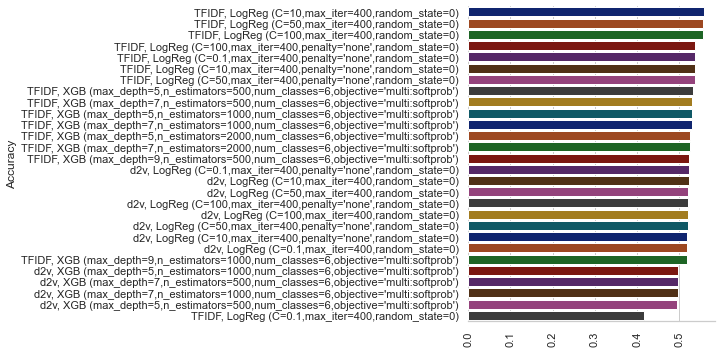

In [95]:
# Plot performances
sns.set_theme(style="whitegrid")


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=score_df, kind="bar",
    y="Full info", x="Accuracy",
    ci="sd", palette="dark", alpha=1, height=5, aspect=2, orient="h"
)

g.despine(left=True)
plt.xticks(rotation=90)
g.set_axis_labels("", "Accuracy")

We can see that the best performing model uses TF-IDF to represent the text, a logistic regression classifier with l2 regularization, where the regularization strength is set at C=10. Its accuracy is ~0.56. For a 6-class classification problem, where baseline accuracy of a random classifier is ~0.17%, this can be considered a decent level of accuracy.

### Building the final model and estimating its performance

In [102]:
# Initialize the TF IDF text model
tfidf_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),  lowercase=True, max_features=150000)
# Initialize logistic regression classifier
clf = LogisticRegression(random_state=0,solver='lbfgs',penalty="l2",C=10,max_iter=400)
# Create a pipeline
pipeline = make_pipeline(tfidf_transformer, clf)
# Fit the pipeline on the full training set
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=400, random_state=0))])

In [103]:
# Get test accuracy and an unbiased estimate of the accuracy on the unseen test set
predictions_train = pipeline.predict(X_train)
predictions_test = pipeline.predict(X_test)

In [104]:
# Print accuracy
print("Training accuracy: "+str(accuracy_score(y_train, predictions_train)))
print("Test accuracy: "+str(accuracy_score(y_test,predictions_test)))

Training accuracy: 1.0
Test accuracy: 0.5596133190118152


In [126]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions_test)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = [ERK, JPL, MM, PS, PT, SYN], 
                     columns = [ERK, JPL, MM, PS, PT, SYN])
cm_df['Total in test set'] = cm_df.sum(axis=1)
total = cm_df.sum(axis=0)
total.name = 'Total Predictions'
# Assign sum of all rows of DataFrame as a new Row
cm_df = cm_df.append(total.transpose())

In [127]:
cm_df

,Erkenntnis,Journal of Philosophical Logic,Minds and Machines,Philosophical Studies,Philosophy & Technology,Synthese,Total in test set
Erkenntnis,43,15,2,75,1,144,280
Journal of Philosophical Logic,9,117,0,9,0,54,189
Minds and Machines,6,0,43,5,15,34,103
Philosophical Studies,24,5,1,304,0,175,509
Philosophy & Technology,1,0,12,3,43,21,80
Synthese,38,33,18,119,1,492,701
Total Predictions,121,170,76,515,60,920,1862


## Explainability using LIME
(https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4)

In [196]:
from lime.lime_text import LimeTextExplainer

### 1. Doc2Vec

In [213]:
# Store names of classes into variabe
class_names = [PS, PT, SYN]
# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

In [153]:
# Define the preprocessing step as Estimator class so we can define a pipeline
class DocVectorizer(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        if isinstance(x_dataset,str):
            return pd.DataFrame([vector_represent(x_dataset)])
        else:
            return pd.DataFrame([vector_represent(x) for x in x_dataset])
        

In [208]:
# Build a pipeline
pipeline_xgb = make_pipeline(DocVectorizer(),
                             xgb.XGBClassifier(max_depth=5,
                                               objective='multi:softmax',
                                               n_estimators=1000, 
                                               num_classes=3,
                                               gamma=10))

In [236]:
# Fit pipeline to training data
pipeline_xgb.fit(X_train,y_train)

Pipeline(steps=[('docvectorizer', DocVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(gamma=10, max_depth=5, n_estimators=1000,
                               num_classes=3, objective='multi:softprob'))])

In [237]:
# Generate XGBoost explanation
explanation = explainer.explain_instance(X_train[6], pipeline_xgb.predict_proba, top_labels=2)

In [238]:
explanation.show_in_notebook()

### 2. TF IDF

In [237]:
# Store names of classes into variabe
class_names = [PS, PT, SYN]
# Initialize LIME explainer
explainer_tf = LimeTextExplainer(class_names=class_names)

In [264]:
# Build pipeline
pipeline_tf = make_pipeline(TfidfVectorizer(stop_words='english',
                                             ngram_range=(1, 3),
                                             lowercase=True,
                                             max_features=150000),
                            LogisticRegression(random_state=0,
                                               penalty="l2", 
                                               C=20,
                                               solver='lbfgs',
                                               max_iter=400))

In [265]:
# Fit pipeline to training data
pipeline_tf.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=150000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=20, max_iter=400, random_state=0))])

In [278]:
# Generate explanation
idx = 2

explanation_tf = explainer_tf.explain_instance(X_test[y_test.index[idx]], pipeline_tf.predict_proba, top_labels=2)
print(pipeline_tf.predict_proba([X_test[y_test.index[idx]]]))
print(pipeline_tf.predict([X_test[y_test.index[idx]]]))
print(y_test[y_test.index[idx]])

[[0.50431108 0.03318987 0.46249905]]
['Philosophical Studies']
Philosophical Studies


In [269]:
pipeline_tf.predict_proba([X_test[y_test.index[1]]])

array([[0.06372845, 0.0207823 , 0.91548925]])

In [279]:
explanation_tf.show_in_notebook()

In [226]:
X_train

1822    Reliabilism and the extra value of knowledge R...
641     Intention-sensitive semantics Intention-sensit...
2341    Not Just Cyberwarfare Not Just Cyberwarfare Br...
2164    Bridging the Responsibility Gap in Automated W...
600     Consciousness in action Consciousness in actio...
                              ...                        
1815    On fraud On fraud Preferably scientific invest...
2093    Group Agency and Artificial Intelligence Group...
1361    Is there a fact of the matter between direct r...
2289    Honesty, Competence, and Trust for Systems Des...
1811    Defeating Manipulation Arguments: Intervention...
Name: Text, Length: 1293, dtype: object